# San Diego AirBnB data

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('/Users/ryankeen/Desktop/UCSD-Python4DS 2/Final Project/listings.csv')

In [4]:
df.shape

(9286, 74)

In [5]:
#drop unwanted columns
drop_vars = ['host_picture_url', 'listing_url', 'host_thumbnail_url', 'scrape_id', 'picture_url', 'host_id', 'host_url', 'calendar_last_scraped', 'first_review', 'neighborhood_overview', 'description', 'host_listings_count', 'host_total_listings_count','host_neighbourhood', 'neighbourhood_group_cleansed',  'neighbourhood', 'bathrooms','calendar_updated', 'license', 'review_scores_accuracy', 'host_about',  'maximum_nights', 'host_location', 'host_name','minimum_minimum_nights','minimum_maximum_nights','maximum_minimum_nights','maximum_maximum_nights', 'number_of_reviews_l30d', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',  'calculated_host_listings_count_shared_rooms', 'name', 'host_since',  'host_acceptance_rate', 'last_scraped','host_verifications', 'has_availability', 'minimum_nights_avg_ntm', 'latitude','longitude', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews_ltm', 'reviews_per_month', 'maximum_nights_avg_ntm']
df = df.drop(drop_vars, axis = 1)

In [6]:
df.shape

(9286, 26)

In [7]:
#drop null values
df = df.dropna()

In [8]:
# make host response rate a float
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
df['host_response_rate'] = df['host_response_rate'].astype(float)
df['host_response_rate'] = df['host_response_rate']/100

In [9]:
# make price a float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

In [10]:
# Convert object to datetime
df['last_review'] = pd.to_datetime(df.last_review)

In [11]:
# create datetime variable for 2-23-2021
today = datetime.date(2021,2,21)
today = pd.to_datetime(today)

In [12]:
# create new variable time from last review
df['time_from_last_review'] = today - df['last_review']
df['time_from_last_review'] = df['time_from_last_review'].dt.days.astype('int64')
df = df.drop('last_review', axis = 1)

In [13]:
# convert amenities to number of amenities
df['num_amenities'] = df['amenities'].apply(lambda x: x.count(',')+1)

In [14]:
#remove properties with zero reviews in last 90 days
df= df[df['time_from_last_review'] <= 90]

In [15]:
#remove propoerties with greater than 5 bedrooms
df = df[df['bedrooms'] <=5 ]

## Remove outliers in 'Price' column

In [16]:
def remove_outlier(df, column):
    Q1 = df[column].quantile(q = .25)
    Q3 = df[column].quantile(q = .75)
    iqr = Q3 - Q1
    iqr_mult = iqr * 1.5
    floor = Q1 - iqr_mult
    ceiling = Q3 + iqr_mult
    return df[(df[column] > floor) & (df[column] < ceiling)]

In [17]:
df = remove_outlier(df, 'price')

## Define variable groups

In [18]:
categorical_vars = ['host_response_time', 'host_is_superhost', 'host_identity_verified', 'host_has_profile_pic', 'property_type', 'room_type', 'instant_bookable', 'bathrooms_text']

In [19]:
num_vars = ['host_response_rate', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'availability_30', 'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'time_from_last_review', 'num_amenities', 'price']

In [20]:
num_varsX = ['host_response_rate', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'availability_30', 'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'time_from_last_review', 'num_amenities']

In [21]:
clean_data = df

## Define x and y vars

In [22]:
# define y
target = ['price']

In [23]:
# define independent variables
features = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_has_profile_pic',
          'host_identity_verified', 'property_type', 'room_type', 'accommodates', 
          'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 
          'availability_30', 'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value', 
          'instant_bookable', 'num_amenities', 'time_from_last_review']

In [24]:
# define X
X = clean_data[features]
y = df[target]

## Training/Testing sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .4, random_state = 79)

## 1: Linear Regression for numeric vars

In [26]:
linreg = LinearRegression()
logreg = LogisticRegression()

In [27]:
X_num = clean_data[num_varsX]
y_num = clean_data[target]

In [28]:
Xnum_train, Xnum_test, ynum_train, ynum_test = train_test_split(X_num, y_num, test_size = .4, random_state = 79)

In [29]:
linreg.fit(Xnum_train, ynum_train)

LinearRegression()

In [30]:
y_prediction = linreg.predict(Xnum_test)

In [31]:
RMSE = sqrt(mean_squared_error(y_true = ynum_test, y_pred = y_prediction))
print(RMSE)

60.080953802827096


In [32]:
r2_score(ynum_test, y_prediction)

0.5228614048808091

In [33]:
y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index(drop = True)

In [34]:
y_prediction = pd.DataFrame(y_prediction)

In [35]:
df1_compare = pd.concat([y_test, y_prediction], axis = 1)
df1_compare.columns = ['y_test', 'y_pred']
df1_compare['difference'] = df1_compare['y_test'] - df1_compare['y_pred']

In [36]:
df1_compare['difference'].describe()

count    1464.000000
mean        2.696004
std        60.040944
min      -238.006380
25%       -35.639152
50%        -6.026667
75%        31.167413
max       249.311171
Name: difference, dtype: float64

## 2: Decision Tree for numeric vars

In [37]:
regressor = DecisionTreeRegressor()
regressor.fit(Xnum_train, ynum_train)

DecisionTreeRegressor()

In [38]:
y_prediction = regressor.predict(Xnum_test)
y_prediction = pd.DataFrame(y_prediction)

In [39]:
RMSE = sqrt(mean_squared_error (y_true = y_test, y_pred = y_prediction))
print(RMSE)

79.25223876791605


In [40]:
r2_score(ynum_test, y_prediction)

0.16977847536567958

## Column Transformer

In [41]:
ct = ColumnTransformer([
    ('Scaler', RobustScaler(), num_varsX),
    ('OHE', OneHotEncoder(sparse = False, handle_unknown = 'ignore'),categorical_vars),
], remainder = 'passthrough')

In [42]:
ct.fit_transform(X_train)

array([[-30.        ,  -1.        ,   0.        , ...,   0.        ,
          0.        ,  33.        ],
       [ -8.        ,  -0.66666667,   0.        , ...,   0.        ,
          0.        , 124.        ],
       [  0.        ,   1.33333333,   2.        , ...,   0.        ,
          0.        , 131.        ],
       ...,
       [  0.        ,  -0.33333333,   0.        , ...,   0.        ,
          0.        , 125.        ],
       [  0.        ,   1.33333333,   2.        , ...,   0.        ,
          0.        , 300.        ],
       [  0.        ,  -0.33333333,   1.        , ...,   0.        ,
          0.        ,  94.        ]])

In [43]:
ct.fit_transform(X_test)

array([[  0.        ,  -1.        ,   0.        , ...,   0.        ,
          0.        ,  44.        ],
       [  0.        ,   0.        ,   1.        , ...,   0.        ,
          0.        , 195.        ],
       [  0.        ,  -0.66666667,   0.        , ...,   0.        ,
          0.        ,  96.        ],
       ...,
       [ -1.        ,   4.        ,   4.        , ...,   0.        ,
          0.        , 400.        ],
       [  0.        ,   0.66666667,   2.        , ...,   0.        ,
          0.        , 225.        ],
       [  0.        ,   1.33333333,   2.        , ...,   0.        ,
          0.        , 154.        ]])

In [44]:
X_train_transform = pd.DataFrame(ct.transform(X_train))

In [45]:
X_test_transform = pd.DataFrame(ct.transform(X_test))
X_test_transform[0]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1459    0.0
1460    0.0
1461   -1.0
1462    0.0
1463    0.0
Name: 0, Length: 1464, dtype: float64

## 3: Linear Regression on transformed data

In [46]:
linreg.fit(X_train_transform, y_train)

LinearRegression()

In [47]:
y_prediction = linreg.predict(X_test_transform)
y_pred_df = pd.DataFrame(y_prediction)

In [48]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred_df))
print(RMSE)

2.025996612584444e-13


In [49]:
r2_score(y_test, y_prediction)

1.0

## 4: Linear Regression Transformed - Pared

In [50]:
drop_vars2 = ['host_is_superhost', 'host_response_time', 'host_response_rate', 'property_type', 
                 'bathrooms_text', 'amenities', 'availability_30', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 
                 'instant_bookable']
df2 = clean_data.drop(drop_vars2, axis = 1)
print(df2.columns)
print(df2.shape)

Index(['id', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_location',
       'time_from_last_review', 'num_amenities'],
      dtype='object')
(3659, 15)


In [51]:
num_vars = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating',
                'review_scores_location', 'time_from_last_review', 'num_amenities']
cat_vars = ['host_has_profile_pic', 'host_identity_verified', 'room_type']
    
X = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating',
            'review_scores_location', 'time_from_last_review', 'num_amenities', 'host_has_profile_pic', 
           'host_identity_verified', 'room_type']
y = ['price']
X = df2[X]
y = df2[y]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 91)

ct = ColumnTransformer([
        ('Scaler', RobustScaler(), num_vars),
        ('OHE', OneHotEncoder(sparse = False, handle_unknown = 'ignore'),cat_vars),
    ], remainder = 'passthrough')
    
ct.fit_transform(X_train)
ct.fit_transform(X_test)

array([[ 0.66666667,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66666667,  1.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.33333333,  2.        ,  1.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.66666667,  0.        , -0.5       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.66666667,  2.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.66666667,  0.        , -0.5       , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
X_train_transform = pd.DataFrame(ct.transform(X_train))

In [54]:
X_test_transform = pd.DataFrame(ct.transform(X_test))

In [55]:
linreg.fit(X_train_transform, y_train)
y_prediction = linreg.predict(X_test_transform)

In [56]:
y_prediction= pd.DataFrame(y_prediction)

In [57]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE)
r2_score(y_test, y_prediction)

58.80810643108105


0.5372364497484763

## Just playing around + visualizations

In [58]:
clean_data.columns

Index(['id', 'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'availability_30', 'number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'time_from_last_review', 'num_amenities'],
      dtype='object')

In [59]:
clean_data.room_type.value_counts()

Entire home/apt    3119
Private room        511
Shared room          23
Hotel room            6
Name: room_type, dtype: int64

In [60]:
concat = pd.concat([X_test, y_test], axis = 1)
concat

,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_location,time_from_last_review,num_amenities,host_has_profile_pic,host_identity_verified,room_type,price
6123,6,2.0,2.0,1,69,95.0,9.0,38,31,t,t,Entire home/apt,107.0
4562,6,2.0,3.0,1,103,90.0,10.0,16,32,t,t,Entire home/apt,250.0
1048,8,3.0,5.0,3,60,95.0,10.0,50,37,t,t,Entire home/apt,219.0
4854,4,2.0,2.0,2,63,93.0,10.0,49,32,t,t,Entire home/apt,104.0
4620,4,1.0,2.0,3,50,98.0,10.0,50,30,t,t,Entire home/apt,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7467,6,1.0,1.0,1,27,85.0,9.0,18,28,t,t,Entire home/apt,194.0
4498,4,1.0,1.0,2,204,100.0,10.0,7,36,t,t,Entire home/apt,126.0
5997,2,1.0,1.0,1,107,88.0,9.0,7,17,t,t,Hotel room,84.0
7483,6,3.0,3.0,3,8,95.0,10.0,84,25,t,t,Entire home/apt,400.0


In [61]:
concat = concat.reset_index()

In [62]:
y_prediction = y_prediction.rename(columns = {0:'y_pred'})

In [63]:
concat = pd.concat ([concat, y_prediction], axis = 1)

In [64]:
concat['diff'] = abs(concat['price'] - concat['y_pred'])

In [65]:
concat = concat.sort_values(by = ['diff'], ascending = False)

In [66]:
gv1 = df['price'] == 97.0
gv2 = df['review_scores_rating'] == 91.0    
gv3 = df['host_response_rate'] == 0.95     
df[gv1 & gv2 & gv3].describe()

,id,host_response_rate,accommodates,bedrooms,beds,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,time_from_last_review,num_amenities
count,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,35126852.0,0.95,8.0,4.0,7.0,97.0,1.0,0.0,37.0,91.0,9.0,10.0,10.0,9.0,9.0,39.0,37.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,35126852.0,0.95,8.0,4.0,7.0,97.0,1.0,0.0,37.0,91.0,9.0,10.0,10.0,9.0,9.0,39.0,37.0
25%,35126852.0,0.95,8.0,4.0,7.0,97.0,1.0,0.0,37.0,91.0,9.0,10.0,10.0,9.0,9.0,39.0,37.0
50%,35126852.0,0.95,8.0,4.0,7.0,97.0,1.0,0.0,37.0,91.0,9.0,10.0,10.0,9.0,9.0,39.0,37.0
75%,35126852.0,0.95,8.0,4.0,7.0,97.0,1.0,0.0,37.0,91.0,9.0,10.0,10.0,9.0,9.0,39.0,37.0
max,35126852.0,0.95,8.0,4.0,7.0,97.0,1.0,0.0,37.0,91.0,9.0,10.0,10.0,9.0,9.0,39.0,37.0


In [67]:
y_test.describe()

,price
count,1098.000000
mean,155.442623
std,86.487925
min,25.000000
25%,95.000000
50%,135.000000
75%,195.750000
max,414.000000


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

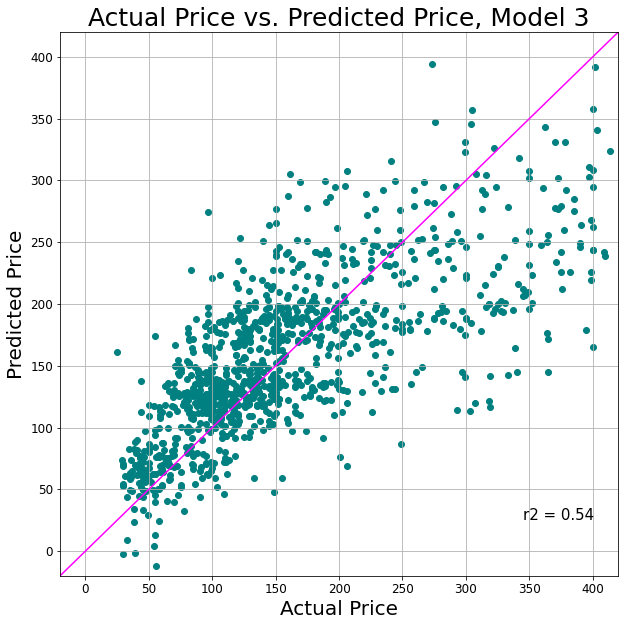

In [85]:
fig, axis = plt.subplots(figsize = (10,10))
plt.scatter(concat['price'].values,concat['y_pred'].values, color = 'teal')
plt.plot([-20, 420], [-20, 420], color = 'fuchsia')
plt.axis ([-20, 420, -20, 420])
axis.set_title('Actual Price vs. Predicted Price, Model 3', fontsize = 25)
axis.set_xlabel('Actual Price', fontsize = 20)
axis.set_ylabel('Predicted Price', fontsize = 20)
axis.tick_params(axis='x', labelsize= 12)
axis.tick_params(axis='y', labelsize= 12)
axis.text(345, 25, 'r2 = 0.54', fontsize = 15)
plt.grid(True)

**word**
*word*
# word
## word

<AxesSubplot:>

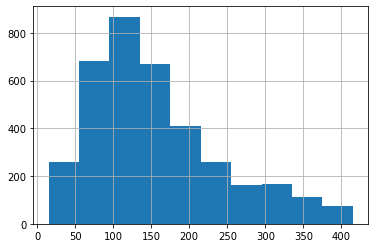

In [90]:
clean_data['price'].hist()

In [94]:
clean_data.groupby('neighbourhood_cleansed')